<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/RECONOCIMIENTO-DE-FORMAS-Y-APRENDIZAJE-COMPUTACIONAL/blob/main/SEMANA%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SEMANA 4
Tema 2. APRENDIZAJE SUPERVISADO

2.1. Modelos de aprendizaje supervisado.

2.2. Proceso de preprocesamiento de datos.

2.3. Visualización básica de datos.

2.4. Escalado de datos.

2.5. Uso de múltiples algoritmos.

Objetivo: Comprender los fundamentos del aprendizaje supervisado, identificando los tipos de problemas que resuelve, los datos que requiere y los modelos que emplea. Además, desarrollar la capacidad de evaluar su rendimiento y aplicarlo en contextos reales, como la clasificación de imágenes, el análisis de datos estructurados y la predicción de valores.

# Semana 4 – Proceso general para aplicar aprendizaje supervisado de principio a fin
**Objetivo:** importar, limpiar, escalar, entrenar 5 algoritmos y comparar resultados.


In [ ]:
# Dependencias base
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

# # Opcional (bonus)
# !pip -q install xgboost
# from xgboost import XGBClassifier



## 1) Importación de datos
- Carga desde CSV (o desde sklearn como alternativa).
- Revisa forma (filas/columnas) y tipos de datos.
- Quita columnas no predictivas (ej. ID).


In [ ]:
# Opción A: nuestro CSV completo
df = pd.read_csv("cancer_dataset_full.csv")

# Opción B: dataset de sklearn (por si hace falta)
# from sklearn.datasets import load_breast_cancer
# data = load_breast_cancer()
# df = pd.DataFrame(data.data, columns=data.feature_names)
# df["Diagnosis"] = data.target

print(df.shape)
df.info()


(569, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   Diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se    

## 2) Exploratory Data Analysis (EDA) mínimo
- Distribucion en el balance de clases
- Detección básica de nulos/duplicados
- Descriptivos rápidos



In [ ]:
if "ID" in df.columns:
    df = df.drop(columns=["ID"])
print("Balance de clases:")
print(df["Diagnosis"].value_counts())

print("\nNulos por columna:\n", df.isna().sum())
print("\nDuplicados:", df.duplicated().sum())



df.describe().T.head(10)


Balance de clases:
Diagnosis
B    357
M    212
Name: count, dtype: int64

Nulos por columna:
 Diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: 

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.78000,28.11000
texture_mean,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.80000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.10000,188.50000
area_mean,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.70000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.10530,0.16340
compactness_mean,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.13040,0.34540
concavity_mean,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.13070,0.42680
concave_points_mean,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.07400,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.19570,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.04996,0.05770,0.06154,0.06612,0.09744


## 3) Limpieza
- Eliminar/ignorar `ID`.
- Imputación simple si hubiera nulos (mediana).
- Definir X (features) e y (etiqueta).

In [ ]:
import pandas as pd

# 1) Quitar ID si existe
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

# 2) Normalizar/asegurar Diagnosis como 0/1
col = df["Diagnosis"]

# Si ya es numérica, la dejamos; si no, la normalizamos y mapeamos
if not pd.api.types.is_numeric_dtype(col):
    col = (col.astype(str).str.strip().str.upper()
              .replace({"B": 0, "M": 1, "0": 0, "1": 1}))

# Convertimos a numérico y, si hay valores raros, los marcamos como NaN
col = pd.to_numeric(col, errors="coerce")

# Si hubiera NaN, los quitamos (filas con etiqueta inválida)
mask_valid = col.notna()
df = df.loc[mask_valid].copy()
df["Diagnosis"] = col.loc[mask_valid].astype(int)

# 3) Separar X (features) e y (etiqueta)
y = df["Diagnosis"].values
X = df.drop(columns=["Diagnosis"]).copy()

# 4) Rellenar nulos en features con la mediana (por si acaso)
X = X.fillna(X.median(numeric_only=True))

print("Forma de X:", X.shape)
print("Distribución de y (0=Benigno, 1=Maligno):")
display(X.head())


Forma de X: (569, 30)
Distribución de y (0=Benigno, 1=Maligno):


/tmp/ipython-input-2898154904.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"B": 0, "M": 1, "0": 0, "1": 1}))


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 4) Split y normalización
- `train_test_split` estratificado.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 4.1) Escalado de características (StandardScaler)

El **escalado** transforma las variables numéricas para que todas estén en la **misma escala**.  
En este caso, con `StandardScaler`, cada variable se convierte a:

- **Media = 0**
- **Desviación estándar = 1**

¿Por qué es importante?  
- Algoritmos como **Regresión Logística, KNN o SVM** son muy sensibles a las diferencias de escala.  
- Sin escalado, una variable con valores grandes (ej. `area_mean`) dominaría sobre otra pequeña (ej. `smoothness_mean`).  

Con el escalado, todas las variables tienen el **mismo peso relativo**.


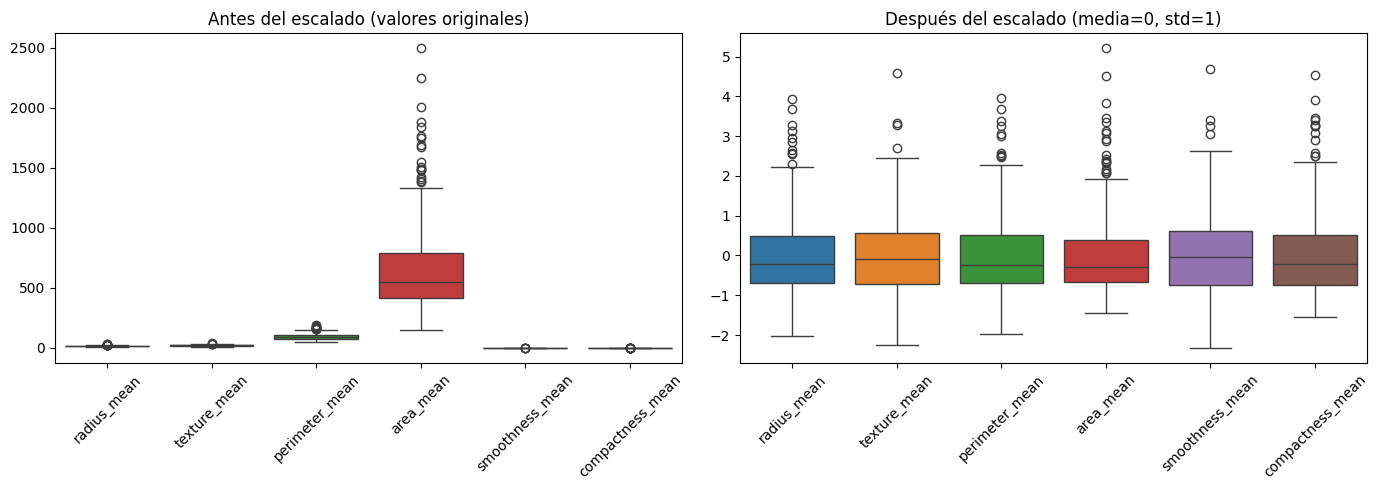

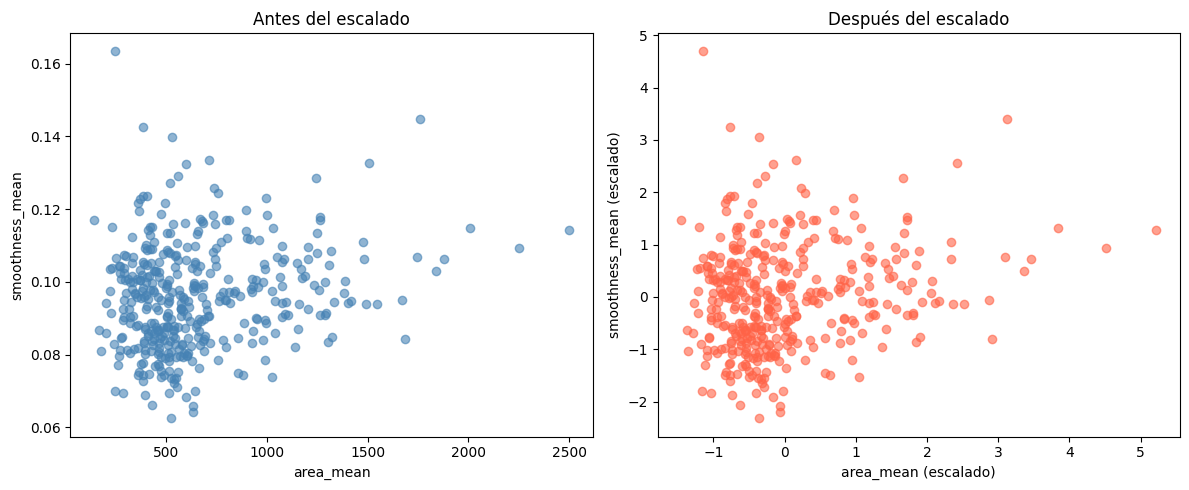

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Escalado
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc  = scaler.transform(X_test)

# Convertimos a DataFrame para graficar
X_train_sc_df = pd.DataFrame(X_train_sc, columns=X_train.columns)

# 1) Boxplot antes y después (solo primeras 6 variables para claridad)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.boxplot(data=X_train[X_train.columns[:6]])
plt.title("Antes del escalado (valores originales)")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.boxplot(data=X_train_sc_df[X_train_sc_df.columns[:6]])
plt.title("Después del escalado (media=0, std=1)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2) Scatter de dos variables antes y después del escalado
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_train["area_mean"], X_train["smoothness_mean"], alpha=0.6, c="steelblue")
plt.xlabel("area_mean"); plt.ylabel("smoothness_mean")
plt.title("Antes del escalado")

plt.subplot(1,2,2)
plt.scatter(X_train_sc_df["area_mean"], X_train_sc_df["smoothness_mean"], alpha=0.6, c="tomato")
plt.xlabel("area_mean (escalado)"); plt.ylabel("smoothness_mean (escalado)")
plt.title("Después del escalado")

plt.tight_layout()
plt.show()


## 5) Modelos y pipelines
- Crear pipeline por modelo para asegurar preprocesamiento consistente.


In [ ]:
# ====== Modelos (5) ======
models = {
    "LogisticRegression": ("scaled", LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)),
    "KNN":                ("scaled", KNeighborsClassifier(n_neighbors=7)),
    "SVM_RBF":            ("scaled", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)),
    "DecisionTree":       ("raw",    DecisionTreeClassifier(random_state=42)),
    "RandomForest":       ("raw",    RandomForestClassifier(n_estimators=300, random_state=42)),
}


# models = {
#     "LogisticRegression": ("scaled", LogisticRegression(random_state=42)),
#     "KNN":                ("scaled", KNeighborsClassifier()),
#     "SVM_RBF":            ("scaled", SVC(random_state=42)),
#     "DecisionTree":       ("raw",    DecisionTreeClassifier(random_state=42)),
#     "RandomForest":       ("raw",    RandomForestClassifier(random_state=42)),
# }
# ====== Entrenar/Evaluar (train/test clásico) ======
rows = []
preds = {}

for name, (which_X, model) in models.items():
    Xtr = X_train_sc if which_X == "scaled" else X_train
    Xte = X_test_sc  if which_X == "scaled" else X_test

    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    preds[name] = y_pred

    # ROC-AUC si hay predict_proba o decision_function
    try:
        y_score = model.predict_proba(Xte)[:, 1]
        auc = roc_auc_score(y_test, y_score)
    except Exception:
        try:
            y_score = model.decision_function(Xte)
            auc = roc_auc_score(y_test, y_score)
        except Exception:
            auc = np.nan

    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": auc
    })

## 6) Validación y comparación
- Métricas: Accuracy, Precision, Recall, F1, ROC-AUC (macro si multiclase).


In [ ]:
results_df = pd.DataFrame(rows).set_index("model").sort_values("f1", ascending=False)
print(results_df.round(3))

# ====== (Opcional) Mejor modelo: reporte y matriz de confusión ======
best = results_df["f1"].idxmax()
print(f"\nMejor por F1: {best}\n")
print(classification_report(y_test, preds[best], target_names=["Benigno (0)", "Maligno (1)"]))

cm = confusion_matrix(y_test, preds[best])
print("Matriz de confusión:\n", cm)

                    accuracy  precision  recall     f1  roc_auc
model                                                          
SVM_RBF                0.982      0.984   0.969  0.976    0.998
LogisticRegression     0.977      0.984   0.953  0.968    0.997
RandomForest           0.977      1.000   0.938  0.968    0.996
KNN                    0.965      1.000   0.906  0.951    0.987
DecisionTree           0.901      0.885   0.844  0.864    0.889

Mejor por F1: SVM_RBF

              precision    recall  f1-score   support

 Benigno (0)       0.98      0.99      0.99       107
 Maligno (1)       0.98      0.97      0.98        64

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Matriz de confusión:
 [[106   1]
 [  2  62]]


## 📊 Comparación de modelos: ¿por qué unos funcionan mejor que otros?

1. **SVM (RBF)**
   - Encuentra **fronteras de decisión no lineales** gracias al kernel RBF.
   - Maximiza el **margen entre clases**, lo que lo hace más robusto.
   - Se beneficia mucho del **escalado de variables**.
   - Resultado: el mejor desempeño global (F1 ≈ 0.98).

2. **Regresión Logística**
   - Supone una **frontera lineal**, pero funciona muy bien porque el dataset es relativamente limpio.
   - Es rápida, interpretable y ofrece probabilidades.
   - Le va excelente después del escalado, aunque no captura relaciones complejas como SVM.

3. **Random Forest**
   - Combina muchos árboles → generaliza mejor que un solo árbol.
   - Tolera ruido y evita sobreajuste, pero puede perder recall en algunos casos.
   - Muy bueno en datasets tabulares, aunque menos suave en sus fronteras.

4. **KNN**
   - Clasifica por cercanía a los vecinos.
   - Depende mucho de la **escala** y del número de vecinos elegido.
   - Funciona bien, pero en fronteras difíciles puede confundirse (recall más bajo).

5. **Árbol de Decisión**
   - Fácil de interpretar, pero tiende a **sobreajustar** con datos pequeños.
   - Sus cortes son “rectangulares”, lo que limita la flexibilidad.
   - Peor desempeño comparado con los demás, aunque útil como punto de partida.

---

### 🧾 Conclusión
- **SVM RBF** se adapta mejor porque ofrece una frontera flexible y robusta.  
- **Modelos lineales (LogReg)** funcionan bien en datasets limpios y balanceados.  
- **Ensamblados (RF)** son estables pero menos precisos aquí.  
- **Modelos simples (Árbol, KNN)** ayudan a entender conceptos, pero no siempre alcanzan la mejor precisión.  



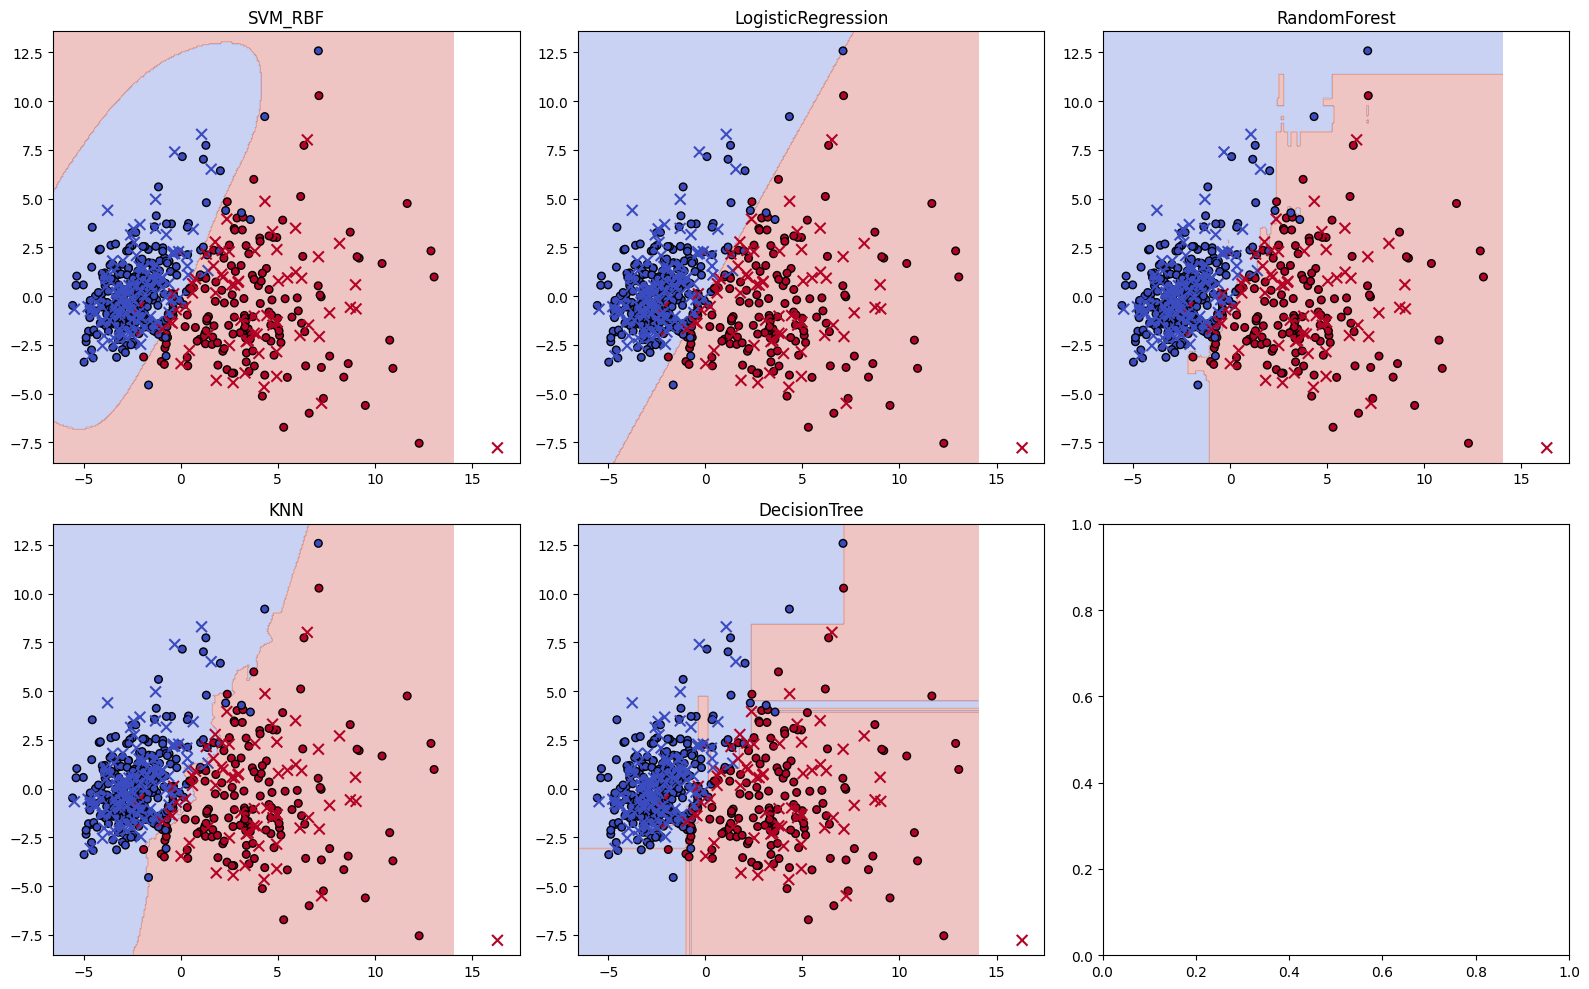

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Reducir a 2 dimensiones con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Reentrenar los modelos en 2D
models_2d = {
    "SVM_RBF": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
}

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# Crear malla para la frontera
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

for i, (name, clf) in enumerate(models_2d.items()):
    clf.fit(X_train_pca, y_train_pca)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Frontera
    axes[i].contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

    # Puntos reales
    axes[i].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_pca,
                    cmap="coolwarm", edgecolor="k", s=30, label="train")
    axes[i].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_pca,
                    cmap="coolwarm", marker="x", s=60, label="test")

    axes[i].set_title(name)

plt.tight_layout()
plt.show()


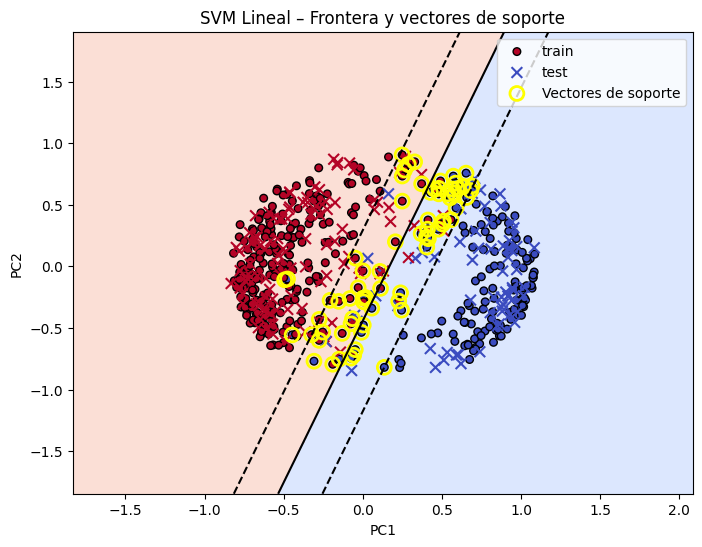

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Cargar datos
data = load_breast_cancer()
X = data.data
y = data.target

# Escalar + normalizar
X_scaled = StandardScaler().fit_transform(X)
X_norm = Normalizer().fit_transform(X_scaled)

# Reducir a 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Entrenar SVM lineal para ver los vectores de soporte
svm_lin = SVC(kernel="linear", C=1.0, random_state=42)
svm_lin.fit(X_train, y_train)

# Crear malla
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = svm_lin.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Gráfico
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z > 0, alpha=0.3, cmap="coolwarm")
plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=["--", "-", "--"], colors="k")

# Puntos
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm",
            s=30, edgecolor="k", label="train")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm",
            marker="x", s=60, label="test")

# Vectores de soporte
plt.scatter(svm_lin.support_vectors_[:, 0], svm_lin.support_vectors_[:, 1],
            s=100, facecolors="none", edgecolors="yellow", linewidths=2,
            label="Vectores de soporte")

plt.title("SVM Lineal – Frontera y vectores de soporte")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


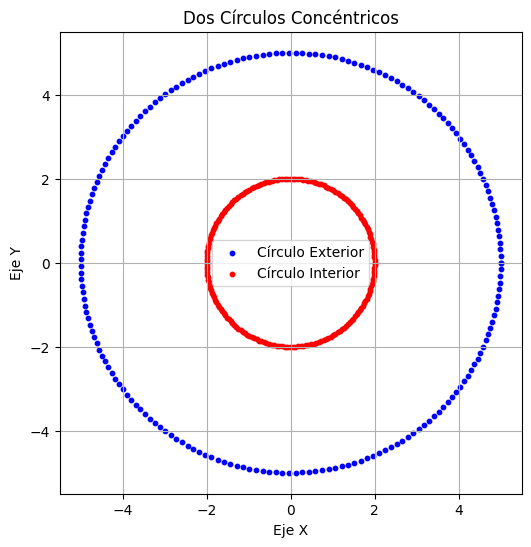

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Función para generar puntos de un círculo
def generar_circulo(radio, centro=(0, 0), num_puntos=200):
    theta = np.linspace(0, 2 * np.pi, num_puntos)
    x = centro[0] + radio * np.cos(theta)
    y = centro[1] + radio * np.sin(theta)
    return x, y

# Parámetros de los círculos
radio_exterior = 5
radio_interior = 2

# Generar puntos para ambos círculos
x1, y1 = generar_circulo(radio_exterior)
x2, y2 = generar_circulo(radio_interior)

# Crear el gráfico de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(x1, y1, color='blue', label='Círculo Exterior', s=10)
plt.scatter(x2, y2, color='red', label='Círculo Interior', s=10)

# Estética del gráfico
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Dos Círculos Concéntricos')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()
plt.grid(True)
plt.show()


Libros

https://github.com/Benlau93/Data-Science-Curriculum/blob/master/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf

https://esl.hohoweiya.xyz/book/The%20Elements%20of%20Statistical%20Learning.pdf


https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/2013_Book_AppliedPredictiveModeling.pdf

#Tarea de la semana

In [ ]:
# --- Cargar datos (elige fuente) ---
# Opción sklearn (ejemplo: wine)
from sklearn.datasets import load_wine
import pandas as pd
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target  # multiclase

# Si usas CSV:
# df = pd.read_csv("tu_dataset.csv")
# (haz el preprocesado necesario: mapear etiquetas, one-hot para categóricas, etc.)

# --- EDA mínimo ---
print(df.shape); print(df.isna().sum().sum(), "nulos")
print(df["target"].value_counts())
display(df.describe().T.head(8))

# --- X, y y split ---
from sklearn.model_selection import train_test_split
y = df["target"].values
X = df.drop(columns=["target"]).copy()
X = X.fillna(X.median(numeric_only=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Escalado para modelos que lo requieren ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc  = scaler.transform(X_test)

# --- Modelos ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report, confusion_matrix)

models = {
    "LogisticRegression": ("scaled", LogisticRegression(max_iter=500, random_state=42)),
    "KNN":                ("scaled", KNeighborsClassifier(n_neighbors=7)),
    "SVM_RBF":            ("scaled", SVC(kernel="rbf", probability=True, random_state=42)),
    "DecisionTree":       ("raw",    DecisionTreeClassifier(random_state=42)),
    "RandomForest":       ("raw",    RandomForestClassifier(n_estimators=300, random_state=42)),
}

# --- Entrenar/Evaluar ---
import numpy as np
rows, preds = [], {}

for name, (mode, clf) in models.items():
    Xtr = X_train_sc if mode == "scaled" else X_train
    Xte = X_test_sc  if mode == "scaled" else X_test

    clf.fit(Xtr, y_train)
    y_pred = clf.predict(Xte)
    preds[name] = y_pred

    row = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
    }
    # Binaria vs multiclase: usa macro para comparar
    avg = "macro" if len(np.unique(y)) > 2 else "binary"
    row["precision"] = precision_score(y_test, y_pred, average=avg, zero_division=0)
    row["recall"]    = recall_score(y_test, y_pred, average=avg, zero_division=0)
    row["f1"]        = f1_score(y_test, y_pred, average=avg, zero_division=0)

    # ROC-AUC solo si binaria y hay proba/decision
    try:
        y_score = clf.predict_proba(Xte)
        if y_score.ndim == 2 and y_score.shape[1] == 2:
            row["roc_auc"] = roc_auc_score(y_test, y_score[:,1])
        else:
            row["roc_auc"] = np.nan
    except:
        row["roc_auc"] = np.nan

    rows.append(row)

results = pd.DataFrame(rows).set_index("model").sort_values("f1", ascending=False)
print(results.round(3))

best = results.index[0]
print(f"\nMejor por F1: {best}")
print(classification_report(y_test, preds[best]))
print("Matriz de confusión:\n", confusion_matrix(y_test, preds[best]))


(178, 14)
0 nulos
target
1    71
0    59
2    48
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66


                    accuracy  precision  recall     f1  roc_auc
model                                                          
RandomForest           1.000      1.000   1.000  1.000      NaN
LogisticRegression     0.981      0.982   0.984  0.983      NaN
SVM_RBF                0.981      0.985   0.978  0.981      NaN
DecisionTree           0.963      0.971   0.959  0.964      NaN
KNN                    0.944      0.943   0.952  0.945      NaN

Mejor por F1: RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54

Matriz de confusión:
 [[18  0  0]
 [ 0 21  0]
 [ 0  0 15]]
